In (deep generative) models, to learn its distribution, we need only 3 parts:
1. model/network structure
2. loss function
3. optimization methods

In MoE, we model the distribution of X as a linear combination of Gaussians.
p(X) = \Sigma_{i} \lambda_i p_{Normal}(\mu_i,\sigma_i). 
The parameters to learn are the \lambda, \mu and \sigma. 
As the distribution density is modeled, we can optimize the (log-)likelyhood as a target.


Optimization can be gradient descent. However, gradient descent suffer from high computation expenses.

In [263]:
# sample the latent distribution
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class Param:
    n = 10000
    d = 2
    p = 3


def lamb2pi(lamb):
    return torch.softmax(torch.tensor(lamb),0).numpy()

def L2sig(L):
    return np.array([np.dot(a,a.T) for a in L])

lamb = np.random.randn(Param.p)
pi = lamb2pi(lamb)
mu = 2* Param.p * (2*np.random.rand(Param.p, Param.d)-1)
L = np.random.randn(Param.p, Param.d, Param.d)
sigma = L2sig(L)

def gen_MoG_samples(pi,mu,sigma,n=Param.n):    
    z = np.random.choice(Param.p, n, p=pi)
    x = np.zeros((n, Param.d))
    for i in range(n):
        x[i] = np.random.multivariate_normal(mu[z[i]], sigma[z[i]])
    return x

def gen_MoG_samples_reparametrized(lamb,mu,L,n=Param.n):    
    z = np.random.choice(Param.p, n, p=lamb2pi(lamb))
    x = np.zeros((n, Param.d))
    for i in range(n):
        x[i] = np.random.multivariate_normal(mu[z[i]], L2sig(L)[z[i]])
    return x

def visual(X):
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    plt.title('Generated Mixture of Gaussians Samples')
    plt.xlabel('X1')
    plt.ylabel('X2')

The way to generate uniform random covariance matrix, can be studied seperately. 

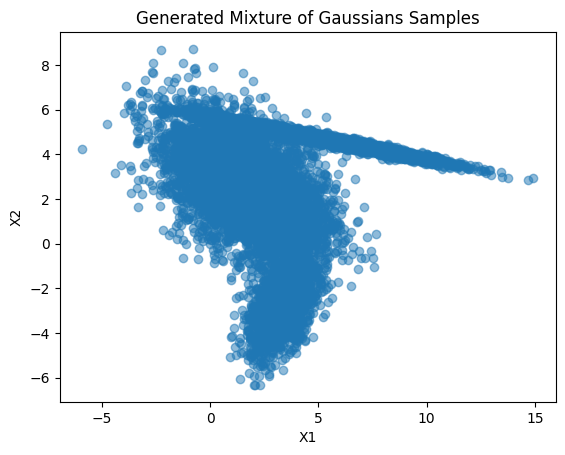

In [264]:
X = gen_MoG_samples_reparametrized(lamb,mu,L)
visual(X)

### Solve MoG using sklearn

In [265]:
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=Param.p, covariance_type='full')
gmm.fit(X)

GaussianMixture(n_components=3)

In [266]:
import pandas as pd
# Extract the learned parameters
learned_pi = gmm.weights_
learned_mu = gmm.means_
learned_sigma = gmm.covariances_

report = pd.DataFrame()

report['learned_pi'] = learned_pi
report['pi'] = pi
report['learned_mu_1'] = learned_mu[:,0]
report['learned_mu_2'] = learned_mu[:,1]
report['mu_1'] = mu[:,0]
report['mu_2'] = mu[:,1] 
for i in range(Param.d):
    for j in range(Param.d):
        report[f'learned_sigma_{i}_{j}'] = learned_sigma[:,i,j]
        report[f'sigma_{i}_{j}'] = L[:,i,j]

report

,learned_pi,pi,learned_mu_1,learned_mu_2,mu_1,mu_2,learned_sigma_0_0,sigma_0_0,learned_sigma_0_1,sigma_0_1,learned_sigma_1_0,sigma_1_0,learned_sigma_1_1,sigma_1_1
0,0.163995,0.155748,3.356012,-2.706391,3.310873,-2.835048,0.620019,-0.392851,0.473309,0.670967,0.473309,0.580796,1.383726,0.937140
1,0.345065,0.496507,5.368650,4.650508,1.585875,2.574160,6.993465,-1.805087,-1.312432,0.320450,-1.312432,1.080009,0.259031,1.267031
2,0.490939,0.347745,1.578673,2.618622,5.414559,4.639508,3.309980,0.433514,-1.372578,2.549402,-1.372578,-0.192028,2.580217,-0.458855


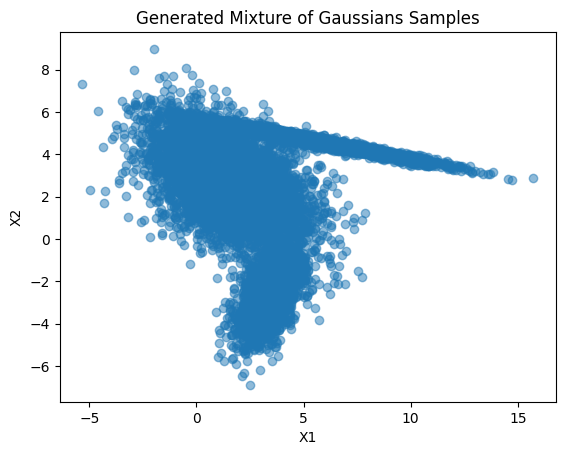

In [267]:
X_learned = gmm.sample(Param.n)[0]
visual(X_learned)

## Schedule
- Implement the SGD algorithm via PyTorch
- Implement the EM algorithm
- Model each component as a neural network

### Implement the SGD algorithm via PyTorch

In [268]:
# SGD
import torch
import torch.nn as nn

X_torch = torch.tensor(X, dtype=torch.float32)

def adapt(X):
    return torch.as_tensor(X,dtype=torch.float32).detach()

def log_likelyhood(X,pi,mu,sigma):
        X = adapt(X)
        pi = adapt(pi)
        mu = adapt(mu)
        sigma = adapt(sigma)
        
        n = X.shape[0]
        d = X.shape[1]
        p = pi.shape[0]
        log_probs = torch.zeros(n,p)
        for i in range(p):
            log_probs[:,i] = torch.distributions.MultivariateNormal(mu[i], sigma[i]).log_prob(X)
        log_probs = log_probs + torch.log(pi)  # Log probabilities with log(pi)
        total_log_likelyhood = torch.logsumexp(log_probs, dim=1).sum()  # Logsumexp over components
        return total_log_likelyhood

class MoG(nn.Module):
    def __init__(self, d, p):
        super(MoG, self).__init__()
        self.lamb = nn.Parameter(torch.randn(p))
        self.mu = nn.Parameter(torch.randn(p, d))
        self.L = nn.Parameter(torch.randn(p, d, d))
        self.d = d
        self.p = p

    def pi(self):
        return torch.softmax(self.lamb,0)
    def sig(self):
        return torch.bmm(self.L, self.L.permute(0,2,1))

    def log_likelyhood(self, X):
        log_probs = torch.zeros(X.shape[0], self.p)
        sigma = self.sig()
        for i in range(self.p):
            log_probs[:,i] = torch.distributions.MultivariateNormal(self.mu[i], sigma[i]).log_prob(X)
        log_probs = log_probs + torch.log_softmax(self.lamb, dim=0)  # Log probabilities with log(pi)
        total_log_likelyhood = torch.logsumexp(log_probs, dim=1).sum()  # Logsumexp over components
        return total_log_likelyhood
    
    def sample(self,n):
        return torch.tensor(gen_MoG_samples(self.pi().detach().numpy(),self.mu.detach().numpy(),self.sig().detach().numpy(),n),dtype=torch.float32)
        

In [258]:
m = MoG(Param.d, Param.p)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
for i in range(1000):
    optimizer.zero_grad()
    loss = -m.log_likelyhood(X_torch)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')

Iteration 0, Loss: 136084.59375
Iteration 100, Loss: 94586.1640625
Iteration 200, Loss: 79111.53125
Iteration 300, Loss: 70153.953125
Iteration 400, Loss: 64019.0
Iteration 500, Loss: 59407.703125
Iteration 600, Loss: 55772.59375
Iteration 700, Loss: 52865.6796875
Iteration 800, Loss: 50547.37109375
Iteration 900, Loss: 48681.89453125


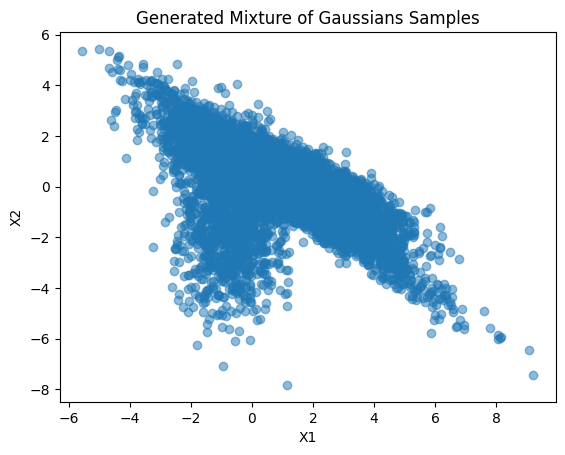

In [259]:
X_learned_gd =m.sample(Param.n).detach().numpy()
visual(X_learned_gd)

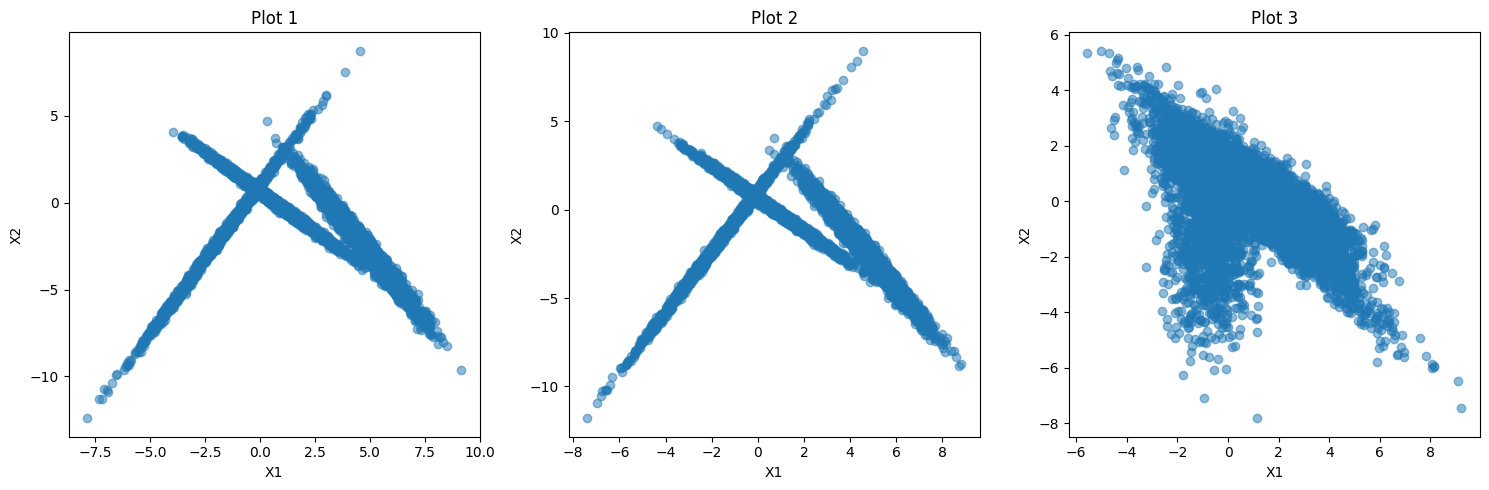

In [260]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Set a wider figure size
for i, (ax, Data) in enumerate(zip(axes, [X, X_learned, X_learned_gd])):
    ax.scatter(Data[:, 0], Data[:, 1], alpha=0.5)  # Call `visual` manually if needed
    ax.set_title(f"Plot {i+1}")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


compare the results:

In [269]:
def kl_divergence(pi1, mu1, sigma1, pi2, mu2, sigma2, mc_samples=10000):
    samples = gen_MoG_samples(pi1,mu1,sigma1,mc_samples)
    log_p = log_likelyhood(samples,pi1,mu1,sigma1)
    log_q = log_likelyhood(samples,pi2,mu2,sigma2)
    return (log_p - log_q).mean().item()

kl_div = kl_divergence(pi, mu, sigma, learned_pi, learned_mu, learned_sigma)
print("KL Divergence for EM:", kl_div)
kl_div = kl_divergence(pi, mu, sigma, m.pi(),m.mu.detach(),m.sig())
print("KL Divergence for SGD:", kl_div)

KL Divergence for EM: 16.421875
KL Divergence for SGD: 160474.859375


### Implement the EM algorithm
https://www.cs.princeton.edu/courses/archive/spring08/cos424/scribe_notes/0311b

EM algorithm is computing the posterier distribution p(z|x) with given parameters, then update the parameters by regarding p(z|x) as independent variables. 

EM algorithm converges, because it increases ELBO, and ELBO is bounded above.

Issue with EM algorithm is that E step can be expensive.

### Model each component as a neural network

It doesn't make sense by "directly" modeling mu, pi, sigma by networks, as in MoE the parameters are already optimal and analytically solvable.

Unless one change the model

